# AON snRNA-seq Analysis

Single-nucleus RNA sequencing analysis of the mouse Anterior Olfactory Nucleus (AON)
using Scanpy to identify molecularly distinct cell populations.

**Results**: 10,966 cells across 28 clusters (6 excitatory, 22 inhibitory)

QC thresholds:
- min_genes = 200, max_genes = 2500
- pct_mt < 5%

**Input**: 10X filtered feature-barcode matrix  
**Output**: `AON_TS.h5ad` with clustered, annotated cells

In [32]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

SEED = 42
np.random.seed(SEED)

sc.settings.set_figure_params(dpi=100, facecolor="white", frameon=False)
sc.settings.verbosity = 2

In [33]:
DATA_DIR = Path("../data").resolve()
AON_DIR = DATA_DIR / "aon_10x"
OUTPUT_DIR = Path("../output").resolve()
OUTPUT_DIR.mkdir(exist_ok=True)

## Data Loading

In [34]:
adata = sc.read_10x_h5(AON_DIR / "filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
print(f"Raw data: {adata.n_obs} cells, {adata.n_vars} genes")

reading /Users/tisyasharma/Documents/Courses/AON_SnRNASeq_TS/data/aon_10x/filtered_feature_bc_matrix.h5


/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:03)
Raw data: 36863 cells, 32285 genes


/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Quality Control

Thresholds:
- min_genes = 200
- max_genes = 2500 (removes likely doublets)
- pct_mt < 5%

High mitochondrial content in snRNA-seq typically indicates damaged nuclei or
cytoplasmic contamination, so filtering at 5% is standard practice.

In [35]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=False)

mt_upper = adata.var_names.str.startswith("MT-").sum()
mt_lower = adata.var["mt"].sum()
print(f"MT- genes (uppercase, R pattern): {mt_upper}")
print(f"mt- genes (lowercase, actual): {mt_lower}")

MT- genes (uppercase, R pattern): 0
mt- genes (lowercase, actual): 13


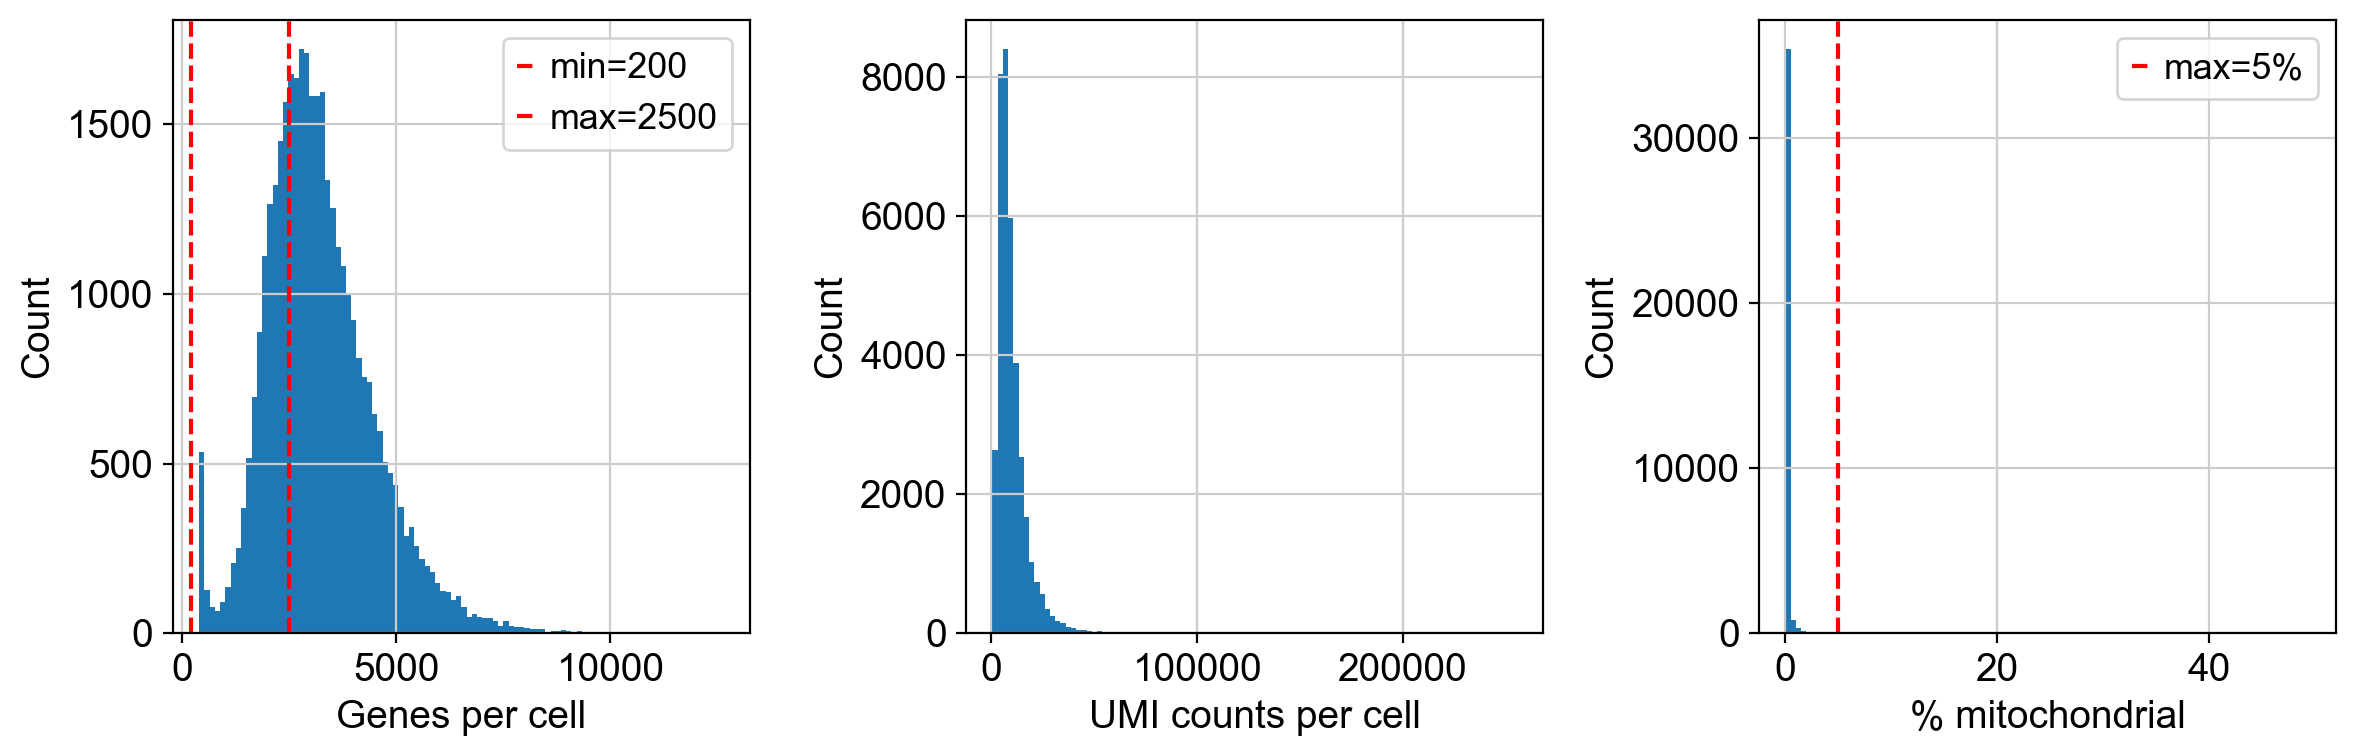

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(adata.obs["n_genes_by_counts"], bins=100)
axes[0].axvline(200, color="red", linestyle="--", label="min=200")
axes[0].axvline(2500, color="red", linestyle="--", label="max=2500")
axes[0].set_xlabel("Genes per cell")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(adata.obs["total_counts"], bins=100)
axes[1].set_xlabel("UMI counts per cell")
axes[1].set_ylabel("Count")

axes[2].hist(adata.obs["pct_counts_mt"], bins=100)
axes[2].axvline(5, color="red", linestyle="--", label="max=5%")
axes[2].set_xlabel("% mitochondrial")
axes[2].set_ylabel("Count")
axes[2].legend()

plt.tight_layout()
plt.show()

In [37]:
print(f"Before filtering: {adata.n_obs} cells")

sc.pp.filter_cells(adata, min_genes=200)
print(f"After min_genes=200: {adata.n_obs} cells")

adata = adata[adata.obs.n_genes_by_counts < 2500, :].copy()
print(f"After max_genes=2500: {adata.n_obs} cells")

adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
print(f"After pct_mt<5%: {adata.n_obs} cells")

sc.pp.filter_genes(adata, min_cells=3)
print(f"After min_cells=3: {adata.n_obs} cells, {adata.n_vars} genes")

Before filtering: 36863 cells
After min_genes=200: 36863 cells
After max_genes=2500: 11031 cells
After pct_mt<5%: 10966 cells
filtered out 10157 genes that are detected in less than 3 cells
After min_cells=3: 10966 cells, 22128 genes


## Normalization

SCTransform uses Pearson residuals from a regularized negative binomial model.
Scanpy's `normalize_pearson_residuals` is the equivalent approach.

If the experimental module is unavailable, we fall back to standard log-normalization
with regression of percent.mt (similar effect to SCTransform's vars.to.regress).

In [38]:
adata.layers["counts"] = adata.X.copy()

try:
    sc.experimental.pp.highly_variable_genes(
        adata,
        n_top_genes=3000,
        flavor="pearson_residuals",
        layer="counts"
    )
    sc.experimental.pp.normalize_pearson_residuals(adata)
    print("Used Pearson residuals normalization (SCTransform equivalent)")
    
except AttributeError:
    print("Pearson residuals not available, using standard normalization")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3", layer="counts")
    adata = adata[:, adata.var.highly_variable].copy()
    sc.pp.regress_out(adata, ["pct_counts_mt"])
    sc.pp.scale(adata, max_value=10)

extracting highly variable genes
computing analytic Pearson residuals on adata.X
    finished (0:00:02)
Used Pearson residuals normalization (SCTransform equivalent)


In [39]:
print(f"Highly variable genes: {adata.var.highly_variable.sum()}")

Highly variable genes: 3000


## Dimensionality Reduction

Computing 50 PCs (standard for scRNA-seq), using top 30 for neighbor graph and UMAP.
Random seeds set for reproducibility.

computing PCA
    with n_comps=50


/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


    finished (0:00:01)


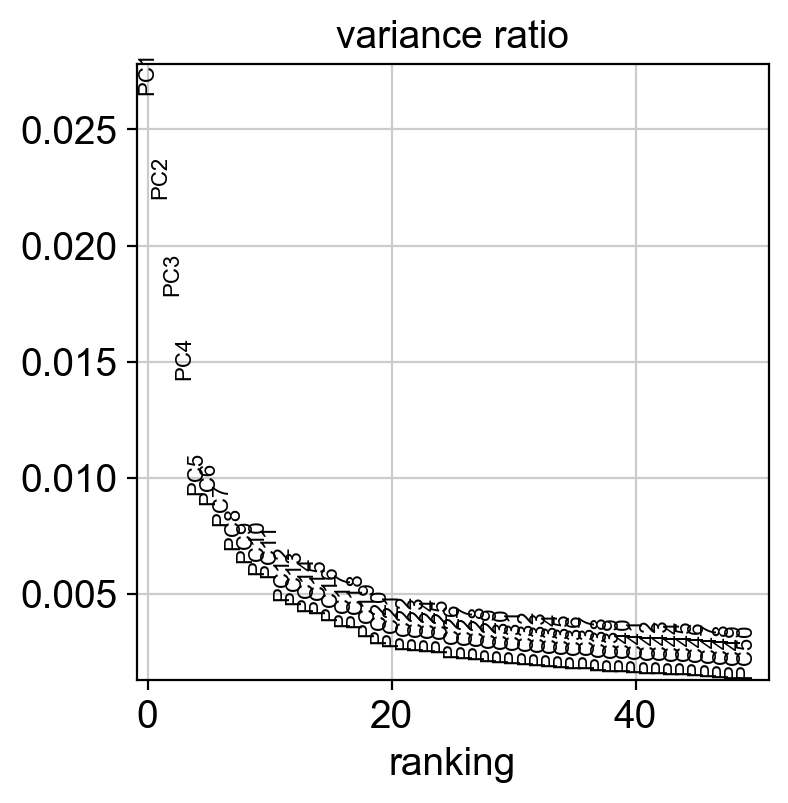

In [40]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=True, random_state=SEED)
sc.pl.pca_variance_ratio(adata, n_pcs=50)

In [41]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, random_state=SEED)
sc.tl.umap(adata, random_state=SEED)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:01)
computing UMAP
    finished (0:00:09)


## Clustering

Seurat uses Louvain clustering by default. Here we use Leiden (igraph flavor), which
is a refined algorithm with better connectivity guarantees. Results are comparable.

Testing multiple resolutions to find an appropriate cluster granularity.

In [42]:
for res in [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
    sc.tl.leiden(
        adata,
        resolution=res,
        random_state=SEED,
        flavor="igraph",
        n_iterations=2,
        key_added=f"leiden_{res}"
    )
    n_clusters = adata.obs[f"leiden_{res}"].nunique()
    print(f"Resolution {res}: {n_clusters} clusters")

running Leiden clustering
    finished (0:00:00)
Resolution 0.8: 21 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.0: 22 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.2: 22 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.4: 25 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.6: 28 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.8: 31 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 2.0: 32 clusters


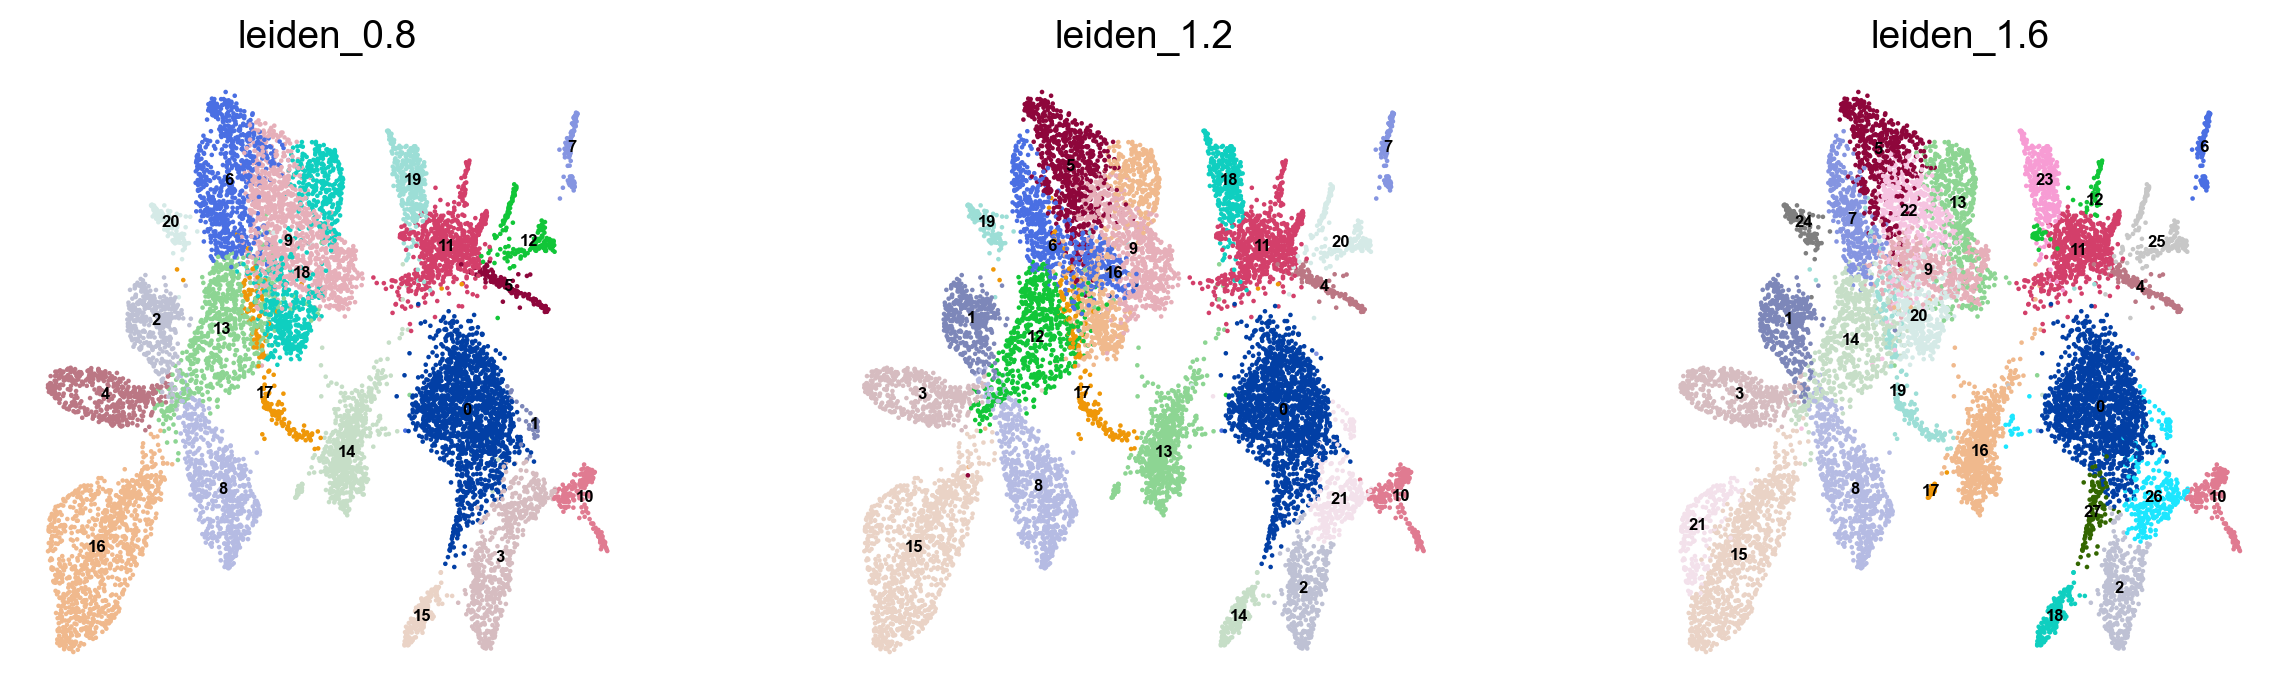

In [43]:
sc.pl.umap(
    adata,
    color=["leiden_0.8", "leiden_1.2", "leiden_1.6"],
    ncols=3,
    legend_loc="on data",
    legend_fontsize=6
)

In [44]:
# Select resolution closest to 27 clusters
# Check output above and adjust. Typically 1.4-1.8 range yields ~27.
best_res = 1.6
adata.obs["leiden"] = adata.obs[f"leiden_{best_res}"]
print(f"Selected resolution {best_res}: {adata.obs['leiden'].nunique()} clusters")

Selected resolution 1.6: 28 clusters


## Neuronal Marker Visualization

Dotplot of canonical neuronal markers to identify excitatory and inhibitory clusters.

In [45]:
neuronal_markers = [
    "Slc17a6",  # vGlut2 (excitatory)
    "Slc17a7",  # vGlut1 (excitatory)
    "Gad1",     # GABAergic (inhibitory)
    "Calb1",    # Calbindin (interneuron)
    "Calb2",    # Calretinin (interneuron)
    "Cck",      # Cholecystokinin (interneuron)
    "Vip",      # VIP (interneuron)
    "Npy",      # Neuropeptide Y (interneuron)
    "Pvalb",    # Parvalbumin (interneuron)
    "Sst",      # Somatostatin (interneuron)
]

markers_present = [m for m in neuronal_markers if m in adata.var_names]
markers_missing = [m for m in neuronal_markers if m not in adata.var_names]
if markers_missing:
    print(f"Missing markers: {markers_missing}")

In [ ]:
sc.pl.dotplot(
    adata,
    markers_present,
    groupby="leiden",
    standard_scale="var",
    title="Neuronal markers by cluster"
)

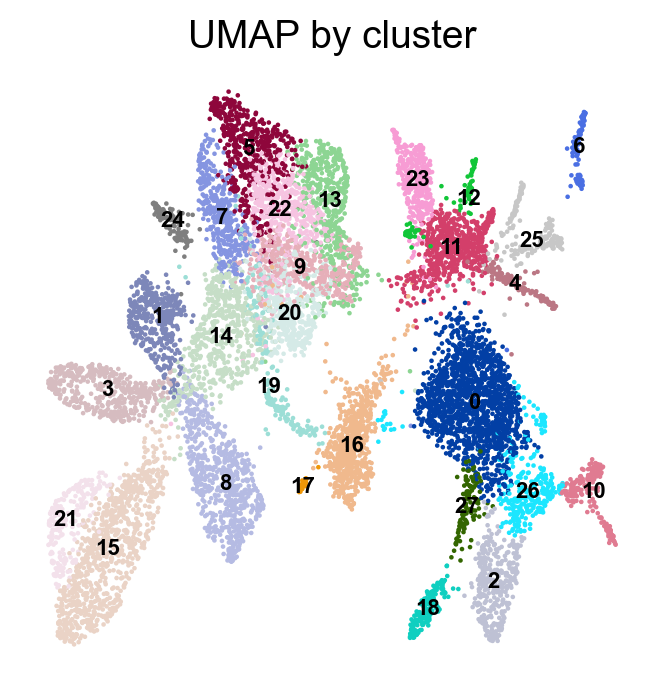

In [47]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", legend_fontsize=8, title="UMAP by cluster")

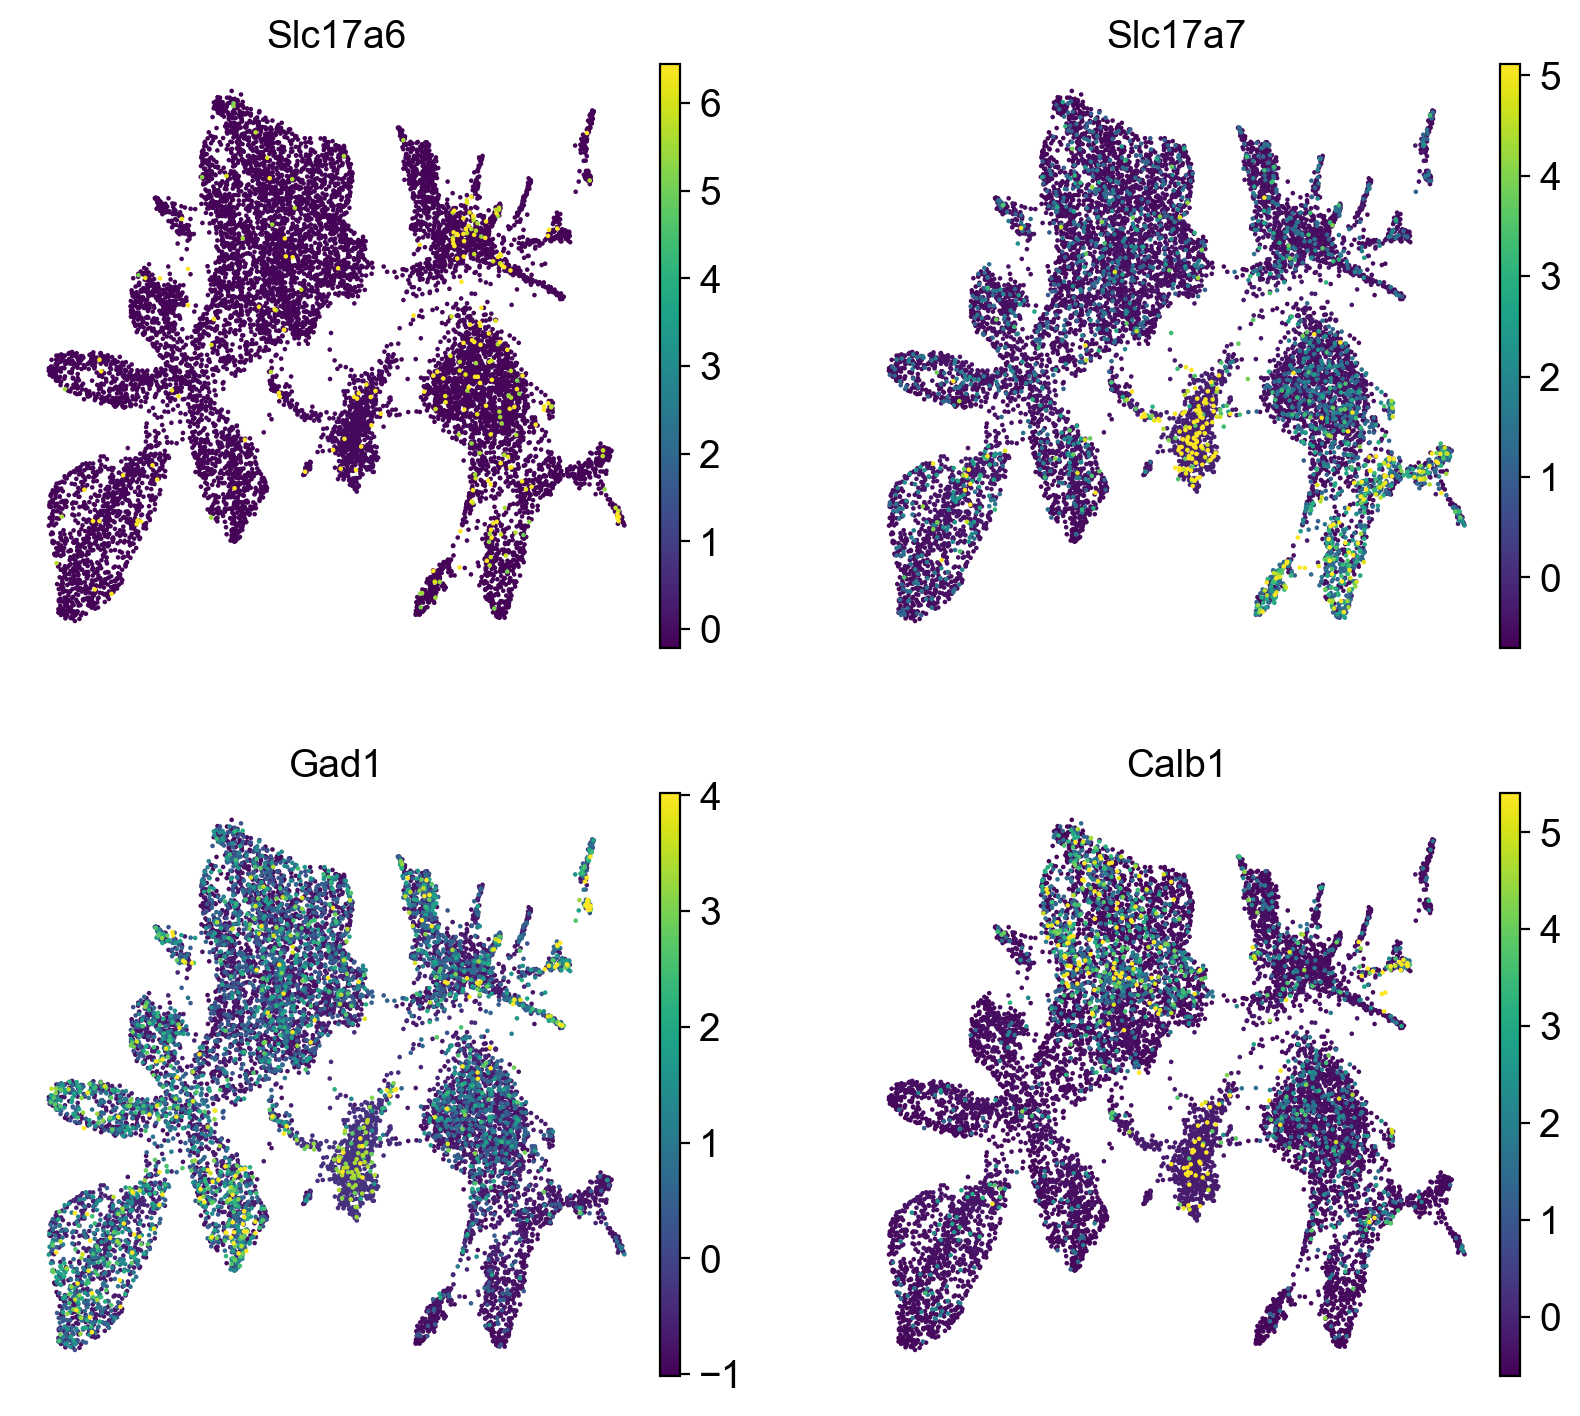

In [48]:
sc.pl.umap(adata, color=markers_present[:4], ncols=2, vmax="p99")

## Marker Gene Discovery

FindAllMarkers equivalent: Wilcoxon rank-sum test, positive markers only

In [49]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", key_added="wilcoxon")

ranking genes
    finished (0:00:17)


/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


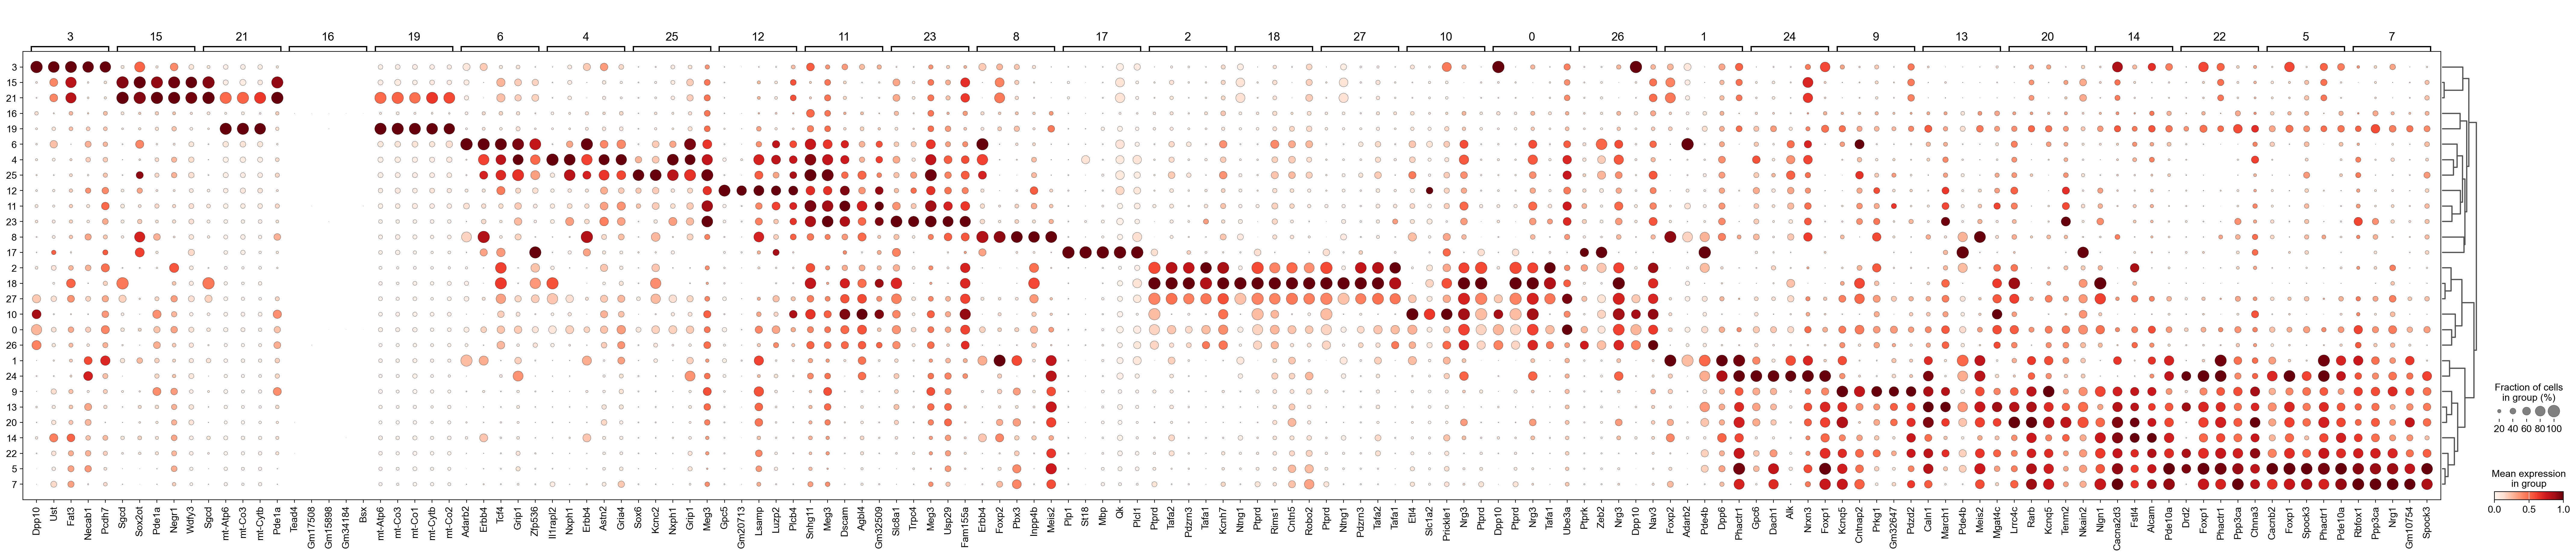

In [50]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden",
    key="wilcoxon",
    n_genes=5,
    standard_scale="var"
)

In [51]:
markers_df = sc.get.rank_genes_groups_df(adata, group=None, key="wilcoxon")
markers_df = markers_df[markers_df["logfoldchanges"] > 0]  # positive only
print(f"Total positive markers: {len(markers_df)}")
markers_df.head(20)

Total positive markers: 191110


group          names     scores  logfoldchanges          pvals  \
74      0          Erbb4  22.773067        3.091951  8.480027e-115   
108     0          Grik1  20.214067        5.501032   7.362212e-91   
238     0         Pcdh15  13.928320        0.257760   4.262644e-44   
241     0         Thsd7b  13.882567        0.010471   8.079705e-44   
253     0        Gm42418  13.510180        3.961869   1.361884e-41   
282     0          Kctd8  12.558088        0.592157   3.589005e-36   
290     0  6530403H02Rik  12.286843        1.412889   1.065873e-34   
321     0          Tshz2  11.311416        1.217517   1.152149e-29   
359     0        Gm10754  10.104543        2.145281   5.274104e-24   
373     0          Olfm3   9.799595        2.823515   1.130377e-22   
379     0          Prkca   9.688848       12.643251   3.362980e-22   
380     0           Aff2   9.684435        1.702485   3.511438e-22   
384     0         Gabrg3   9.584625        0.303173   9.279377e-22   
390     0         Sorcs1   9.452627        0.890498   3.304317e-21   
401     0        Col25a1   9.321690        3.979789   1.145018e-20   
444     0           Dner   8.543997        2.388727   1.296575e-17   
474     0         Stxbp6   8.119140        0.635549   4.695007e-16   
477     0  C130073E24Rik   8.046824        3.896297   8.497007e-16   
484     0         Pde10a   7.972615        1.029019   1.553515e-15   
488     0         Greb1l   7.954279        5.257483   1.801769e-15   

         pvals_adj  
74   2.375266e-112  
108   1.404405e-88  
238   3.698972e-42  
241   6.929756e-42  
253   1.103874e-39  
282   2.553617e-34  
290   7.324734e-33  
321   7.042752e-28  
359   2.812178e-22  
373   5.790044e-21  
379   1.691273e-20  
380   1.761929e-20  
384   4.603902e-20  
390   1.610527e-19  
401   5.413882e-19  
444   5.485777e-16  
474   1.855198e-14  
477   3.333719e-14  
484   6.009821e-14  
488   6.909799e-14

In [52]:
top5_per_cluster = markers_df.groupby("group", observed=True).head(5)
top5_per_cluster.to_csv(OUTPUT_DIR / "top5_markers_per_cluster_TS.csv", index=False)
print(f"Saved top 5 markers per cluster to {OUTPUT_DIR / 'top5_markers_per_cluster_TS.csv'}")

Saved top 5 markers per cluster to /Users/tisyasharma/Documents/Courses/AON_SnRNASeq_TS/output/top5_markers_per_cluster_TS.csv


## Excitatory vs Inhibitory Classification

Classify clusters based on Slc17a7 (excitatory) vs Gad1 (inhibitory) expression

In [53]:
cluster_expr = pd.DataFrame(index=adata.obs["leiden"].cat.categories)

for gene in ["Slc17a7", "Gad1"]:
    if gene in adata.var_names:
        gene_idx = adata.var_names.get_loc(gene)
        expr = adata.layers["counts"][:, gene_idx].toarray().flatten()
        expr_series = pd.Series(expr, index=adata.obs.index)
        cluster_expr[gene] = expr_series.groupby(adata.obs["leiden"], observed=True).mean()

cluster_expr["ratio"] = cluster_expr["Slc17a7"] / (cluster_expr["Gad1"] + 0.01)
cluster_expr["cell_class"] = np.where(cluster_expr["ratio"] > 1, "Excitatory", "Inhibitory")
cluster_expr

Slc17a7      Gad1     ratio  cell_class
0   0.253999  0.360205  0.686103  Inhibitory
1   0.154639  0.721649  0.211357  Inhibitory
2   1.017751  0.115385  8.117036  Excitatory
3   0.162162  0.844595  0.189753  Inhibitory
4   0.147651  0.798658  0.182588  Inhibitory
5   0.165029  0.705305  0.230712  Inhibitory
6   0.206612  1.685950  0.121826  Inhibitory
7   0.165375  0.516796  0.313926  Inhibitory
8   0.157576  0.948485  0.164401  Inhibitory
9   0.136161  0.526786  0.253659  Inhibitory
10  0.871287  0.128713  6.281227  Excitatory
11  0.156958  0.551780  0.279394  Inhibitory
12  0.209877  0.407407  0.502810  Inhibitory
13  0.164859  0.572668  0.282938  Inhibitory
14  0.177358  0.516981  0.336556  Inhibitory
15  0.168605  0.654651  0.253674  Inhibitory
16  0.199702  0.171386  1.100978  Excitatory
17  0.093750  0.187500  0.474684  Inhibitory
18  1.185430  0.112583  9.670448  Excitatory
19  0.195000  0.575000  0.333333  Inhibitory
20  0.129114  0.508861  0.248841  Inhibitory
21  0.183168  0.712871  0.253390  Inhibitory
22  0.149194  0.590726  0.248356  Inhibitory
23  0.166667  0.757310  0.217209  Inhibitory
24  0.190909  0.954545  0.197926  Inhibitory
25  0.163158  0.826316  0.195091  Inhibitory
26  0.901961  0.130719  6.409660  Excitatory
27  0.482143  0.383929  1.223935  Excitatory

In [54]:
excitatory_clusters = cluster_expr[cluster_expr["cell_class"] == "Excitatory"].index.tolist()
inhibitory_clusters = cluster_expr[cluster_expr["cell_class"] == "Inhibitory"].index.tolist()

print(f"Excitatory clusters ({len(excitatory_clusters)}): {excitatory_clusters}")
print(f"Inhibitory clusters ({len(inhibitory_clusters)}): {inhibitory_clusters}")

Excitatory clusters (6): ['2', '10', '16', '18', '26', '27']
Inhibitory clusters (22): ['0', '1', '3', '4', '5', '6', '7', '8', '9', '11', '12', '13', '14', '15', '17', '19', '20', '21', '22', '23', '24', '25']


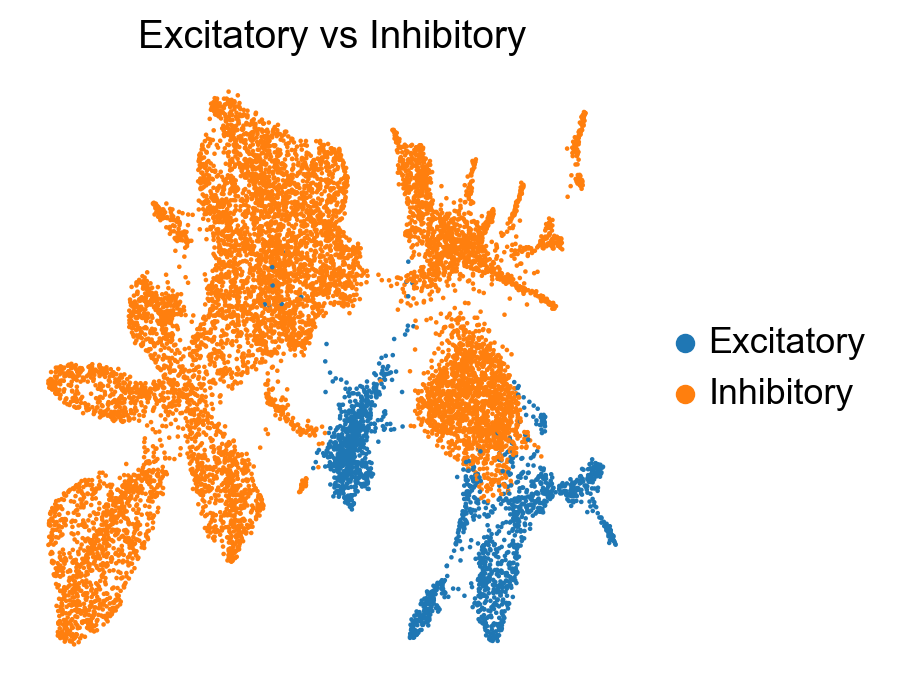

In [55]:
adata.obs["cell_class"] = adata.obs["leiden"].map(cluster_expr["cell_class"].to_dict())
sc.pl.umap(adata, color="cell_class", title="Excitatory vs Inhibitory")

## Candidate Gene Analysis

Visualize expression of candidate marker genes for contralaterally-projecting AON neurons.

In [56]:
candidates_df = pd.read_csv(AON_DIR / "Candidate_Genes.csv")
candidate_genes = candidates_df["GeneName"].tolist()

genes_found = [g for g in candidate_genes if g in adata.var_names]
genes_missing = [g for g in candidate_genes if g not in adata.var_names]

print(f"Candidate genes found: {len(genes_found)}/{len(candidate_genes)}")
if genes_missing:
    print(f"Missing: {genes_missing[:10]}{'...' if len(genes_missing) > 10 else ''}")

Candidate genes found: 118/118


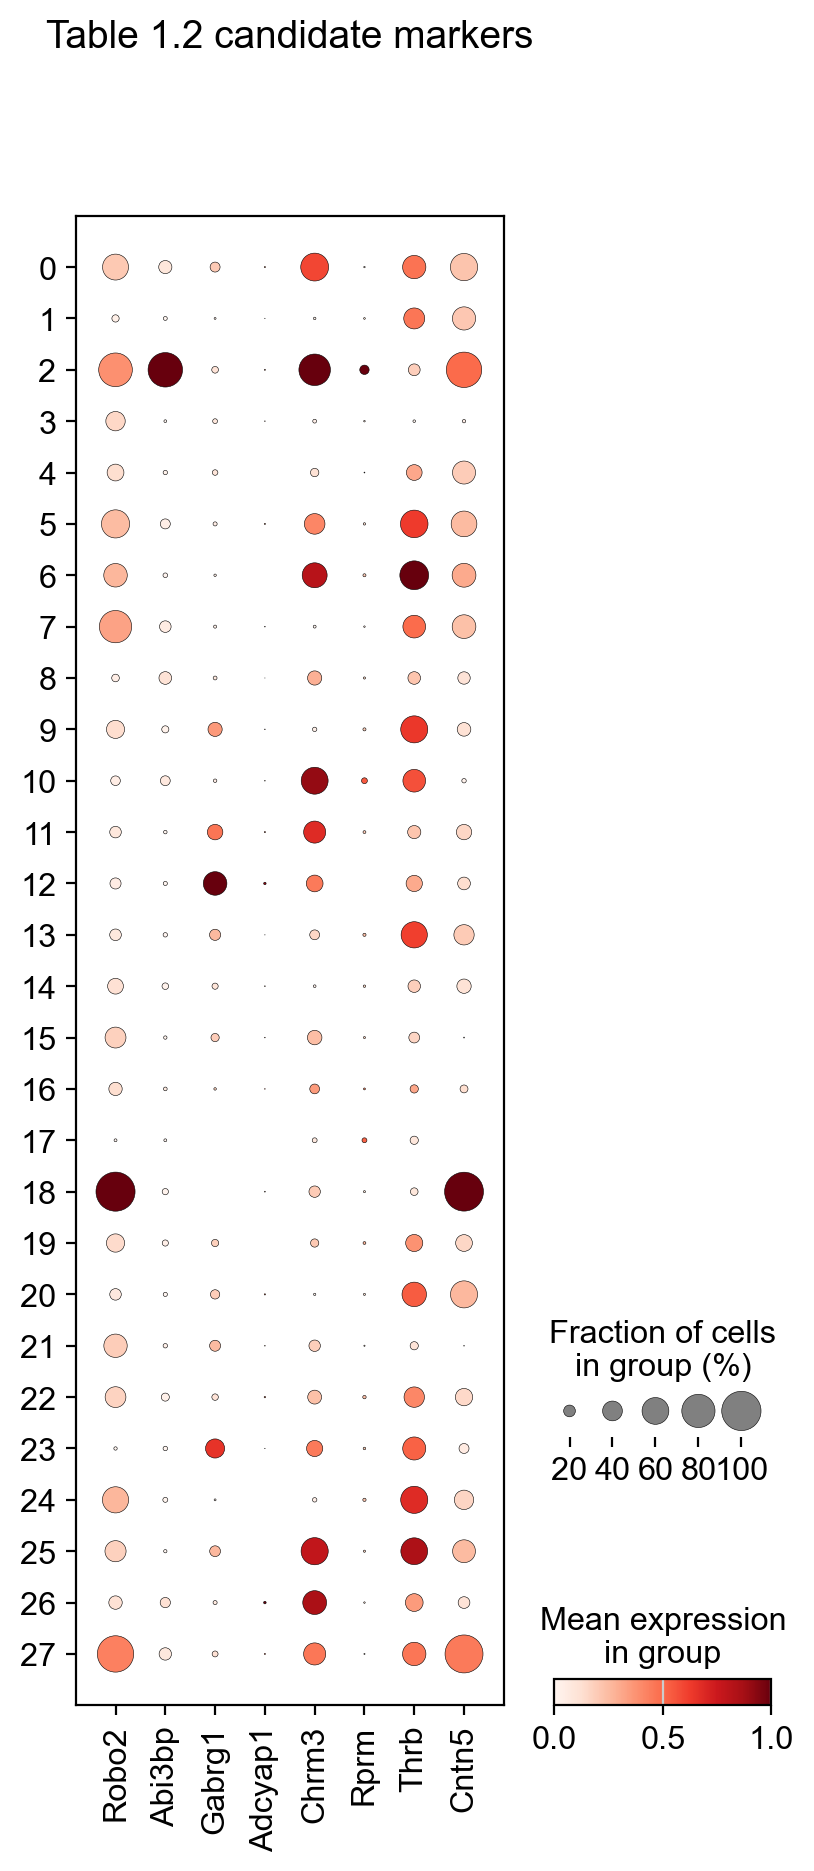

In [57]:
table_1_2_genes = ["Robo2", "Abi3bp", "Gabrg1", "Adcyap1", "Chrm3", "Rprm", "Thrb", "Cntn5"]
table_genes_present = [g for g in table_1_2_genes if g in adata.var_names]

if table_genes_present:
    sc.pl.dotplot(
        adata,
        table_genes_present,
        groupby="leiden",
        standard_scale="var",
        title="Table 1.2 candidate markers"
    )

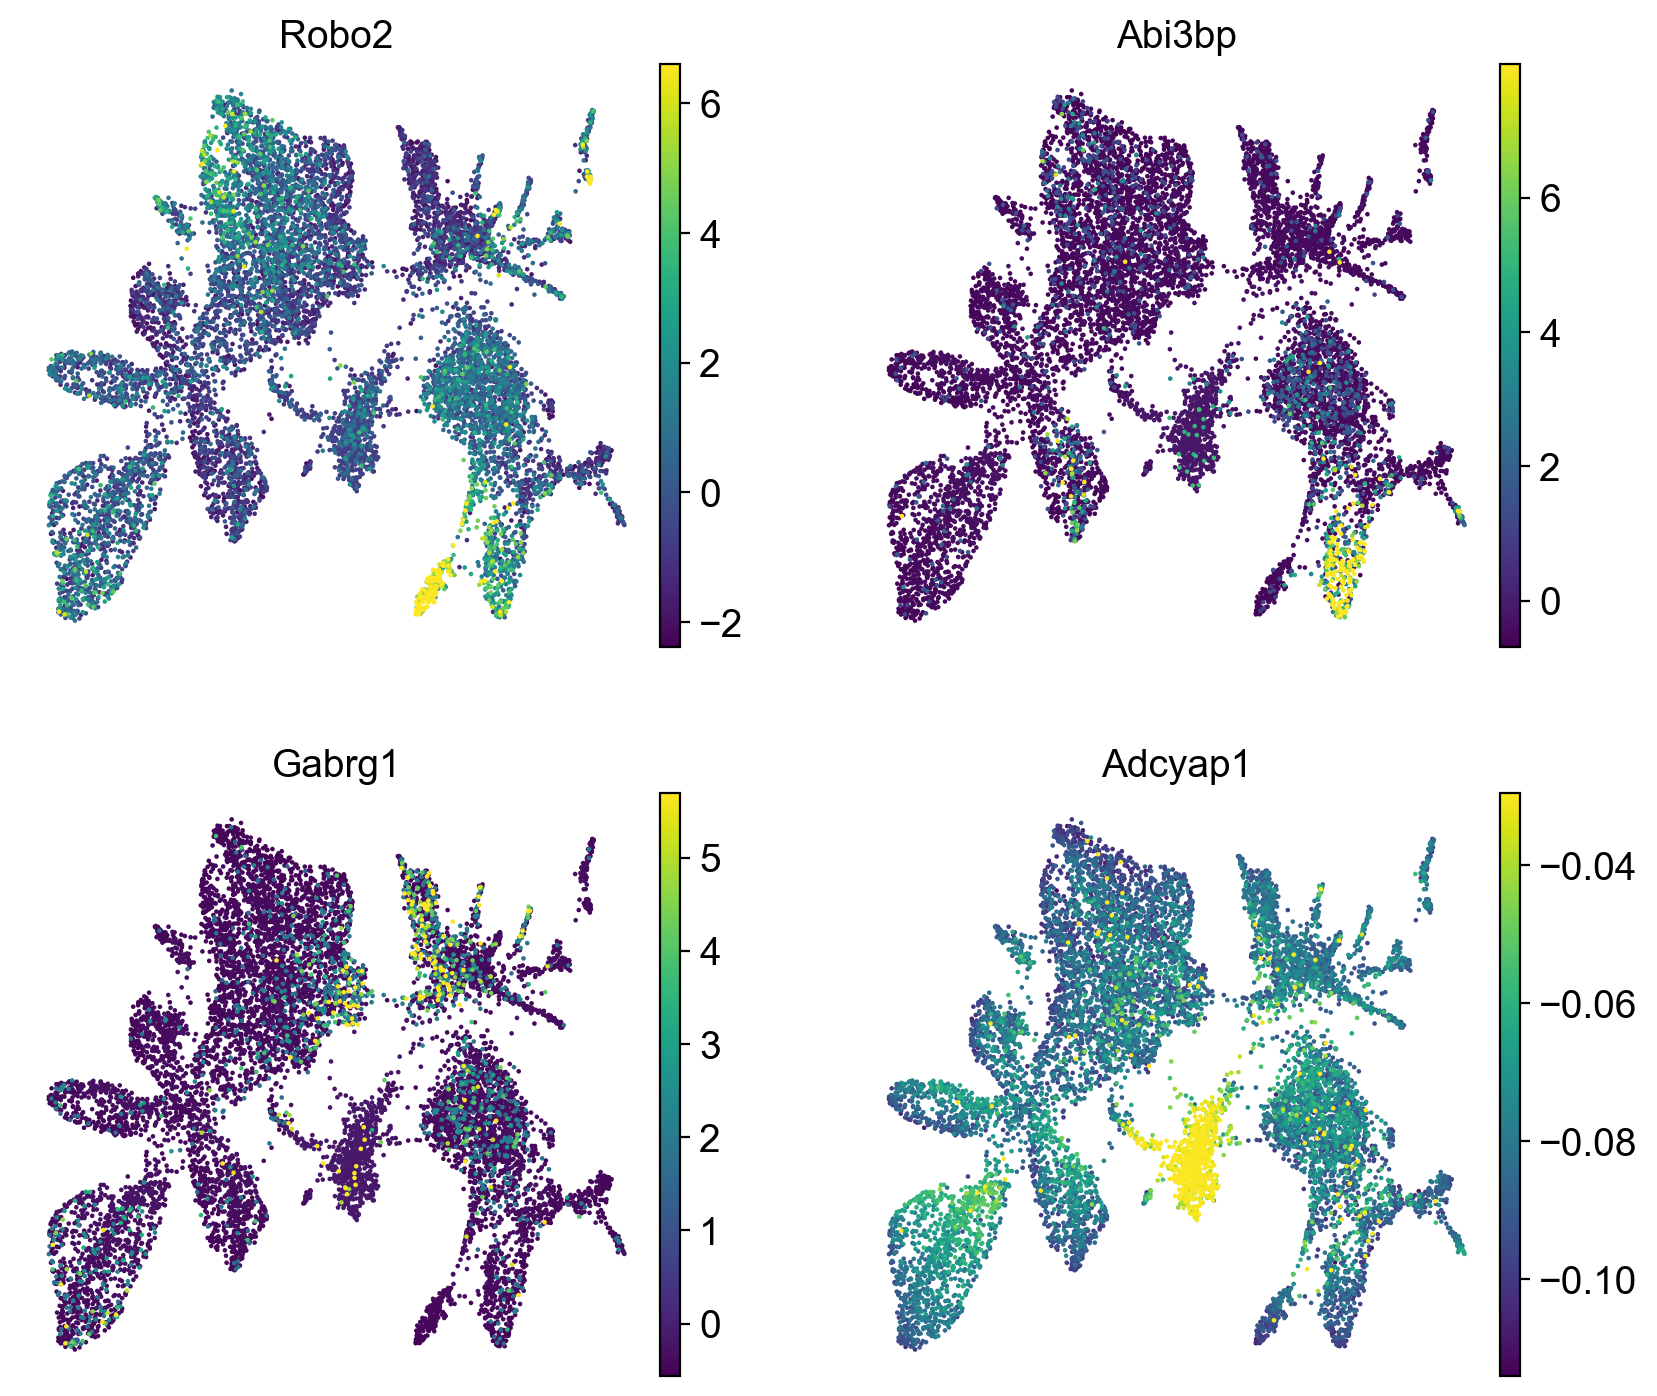

In [58]:
if table_genes_present:
    sc.pl.umap(adata, color=table_genes_present[:4], ncols=2, vmax="p99")

## Cluster Statistics

In [59]:
cluster_stats = adata.obs.groupby("leiden", observed=True).agg(
    n_cells=("leiden", "size"),
    mean_genes=("n_genes_by_counts", "mean"),
    mean_counts=("total_counts", "mean"),
    mean_pct_mt=("pct_counts_mt", "mean")
).round(1)

cluster_stats["cell_class"] = cluster_stats.index.map(cluster_expr["cell_class"].to_dict())
cluster_stats = cluster_stats.sort_index(key=lambda x: x.astype(int))

flagged = []
for idx, row in cluster_stats.iterrows():
    if row["mean_genes"] < 800:
        flagged.append(f"Cluster {idx}: unusually low gene count ({row['mean_genes']:.0f})")
    if row["mean_pct_mt"] > 1.0:
        flagged.append(f"Cluster {idx}: elevated MT% ({row['mean_pct_mt']:.1f}%)")

print(cluster_stats.to_string())

if flagged:
    print("\nQC flags:")
    for f in flagged:
        print(f"  - {f}")

        n_cells  mean_genes  mean_counts  mean_pct_mt  cell_class
leiden                                                           
0          1563      1921.6  3919.100098          0.1  Inhibitory
1           388      2027.0  4256.100098          0.1  Inhibitory
2           338      2116.7  4603.200195          0.0  Excitatory
3           444      1932.0  3893.500000          0.1  Inhibitory
4           149      2093.8  4019.199951          0.1  Inhibitory
5           509      2134.5  4878.899902          0.0  Inhibitory
6           121      2122.2  4394.500000          0.2  Inhibitory
7           387      2168.8  4877.100098          0.0  Inhibitory
8           660      1954.0  3919.500000          0.1  Inhibitory
9           448      2114.6  4576.899902          0.0  Inhibitory
10          202      2154.4  4438.799805          0.1  Excitatory
11          618      2098.0  4017.300049          0.1  Inhibitory
12           81      2019.0  3889.000000          0.1  Inhibitory
13        

In [60]:
cluster_stats.to_csv(OUTPUT_DIR / "cluster_stats_TS.csv")
print(f"Saved cluster stats to {OUTPUT_DIR / 'cluster_stats_TS.csv'}")

Saved cluster stats to /Users/tisyasharma/Documents/Courses/AON_SnRNASeq_TS/output/cluster_stats_TS.csv


## Summary

In [61]:
print("Analysis Summary")
print(f"Total cells: {adata.n_obs:,}")
print(f"Total genes: {adata.n_vars:,}")
print(f"Clusters: {adata.obs['leiden'].nunique()}")
print(f"Excitatory: {len(excitatory_clusters)}")
print(f"Inhibitory: {len(inhibitory_clusters)}")

Analysis Summary
Total cells: 10,966
Total genes: 22,128
Clusters: 28
Excitatory: 6
Inhibitory: 22


## Save Output

In [62]:
output_path = AON_DIR / "AON_TS.h5ad"
adata.write(output_path)
print(f"Saved to {output_path}")
print(f"Random seed used: {SEED} (for reproducibility)")

Saved to /Users/tisyasharma/Documents/Courses/AON_SnRNASeq_TS/data/aon_10x/AON_TS.h5ad
Random seed used: 42 (for reproducibility)
